TalkingData AdTracking Fraud Detection
-----------------------
*Luiz Sampaio e Rodrigo Escorcio* - Prof: Renato Souza

Nome do Grupo: *escorcio e sampaio*

Objetiva-se fazer uma análise preditiva dos dados da competição "TalkingData AdTracking Fraud Detection Challenge" do Kaggle (https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection)

Os dados consistem de informações para cada click, como: IP, o aplicativo que estava sendo utilizado, o aparelho utilizado, a versão do sistema operacional do aparelho, o horário do click, se o usuário de fato fez o download e que horas foi feito.

In [1]:
# Importando bibliotecas

import os
import sys
import time
import pickle
import itertools
import pandas as pd
import numpy as np
import pylab

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
csvtrain = "train.csv"
csvtest = "test.csv" #declarar (utilizamos uma parcela dos dados, já que nao foi possivel rodar na maquina virtual) 

In [3]:
df_train = pd.read_csv(csvtrain) #importar dados

df_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,70335,3,1,8,130,07/11/2017,04:21:42,0
1,357443,15,1,13,265,09/11/2017,02:02:34,0
2,37515,13,1,37,477,06/11/2017,22:55:26,0
3,3219,9,1,19,215,07/11/2017,04:00:26,0
4,61800,15,1,9,130,09/11/2017,03:19:46,0


In [4]:
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
lb = LabelBinarizer()
mlb = MultiLabelBinarizer()

In [5]:
num = df_train['app'].values
N = np.shape(np.unique(num))[0] 

lista = []
for i in range(N):
    lista.append('app'+str(i))
    
apps = pd.DataFrame(lb.fit_transform(df_train['app'].values),columns=lista)
df_train = pd.concat([df_train,apps], axis=1)

In [6]:
num = df_train['device'].values
M = np.shape(np.unique(num))[0] 

lista = []
for i in range(M):
    lista.append('device'+str(i))

devices = pd.DataFrame(lb.fit_transform(df_train['device'].values),columns=lista)
df_train = pd.concat([df_train,devices], axis=1)

In [7]:
num = df_train['os'].values
O = np.shape(np.unique(num))[0] 

lista = []
for i in range(O):
    lista.append('os'+str(i))

oss = pd.DataFrame(lb.fit_transform(df_train['os'].values),columns=lista)
df_train = pd.concat([df_train,oss], axis=1)

In [8]:
num = df_train['channel'].values
P = np.shape(np.unique(num))[0] 

lista = []
for i in range(P):
    lista.append('channel'+str(i))

channels = pd.DataFrame(lb.fit_transform(df_train['channel'].values),columns=lista)
df_train = pd.concat([df_train,channels], axis=1)

df_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,app0,app1,...,channel151,channel152,channel153,channel154,channel155,channel156,channel157,channel158,channel159,channel160
0,70335,3,1,8,130,07/11/2017,04:21:42,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,357443,15,1,13,265,09/11/2017,02:02:34,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,37515,13,1,37,477,06/11/2017,22:55:26,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3219,9,1,19,215,07/11/2017,04:00:26,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,61800,15,1,9,130,09/11/2017,03:19:46,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
tmp = df_train['attributed_time']
tmp2 = tmp.tolist()
lista = []
for time in tmp2:
    stime = time.split(":")
    lista.append((int(stime[0])*3600+int(stime[1])*60+int(stime[2]))/86400.0)

times = pd.DataFrame(lista,columns=["attr_time"])
df_train = pd.concat([df_train,times], axis=1)

tmp3 = df_train['is_attributed']
tmp4 = tmp3.tolist()
lista = []
for time in tmp4:
    if time!='0':
        stime = 1
    else:
        stime = int(time)
    lista.append(stime)

times = pd.DataFrame(lista,columns=["is_attr"])
df_train = pd.concat([df_train,times], axis=1)

df_train2 = df_train.drop(['ip','app','device','os','channel','click_time','attributed_time','is_attributed'], axis=1)

In [10]:
from sklearn import model_selection

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clf_eval(clf, X, y_true, classes=['Nao Sobreviveu', 'Sobreviveu']):
    y_pred = clf.predict(X)
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=classes)
    return roc_auc_score(y_true, y_pred)

In [11]:
# Vou pegar só alguns pontos, depois tem que mudar!!!!

train_data = df_train2.values
X_train = train_data[0:4000,0:-1]
y_train = train_data[0:4000,-1]


#### ATENÇÃO ####

In [12]:
X_traincv, X_testcv, y_traincv, y_testcv = model_selection.train_test_split(X_train,
                                                                            y_train,
                                                                            test_size=0.2,
                                                                            random_state=0)

print(X_traincv.shape)
print(X_testcv.shape)
print(y_traincv.shape)
print(y_testcv.shape)

(3200, 553)
(800, 553)
(3200,)
(800,)


In [13]:
print(len(y_traincv[y_traincv == 0]))
print(len(y_traincv[y_traincv == 1]))

3194
6


In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(kind='regular')
X_traincv_res, y_traincv_res = smote.fit_sample(X_traincv, y_traincv)

print(len(y_traincv_res[y_traincv_res == 0]))
print(len(y_traincv_res[y_traincv_res == 1]))

3194
3194


**Support Vector Machine**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.95      0.97       798
    Sobreviveu       0.05      1.00      0.09         2

   avg / total       1.00      0.95      0.97       800

ROC Score: 0.974310776942
Accuracy Score: 0.94875
Average Precision Score: 0.046511627907
f1 Score: 0.0888888888889
Confusion matrix, without normalization
[[757  41]
 [  0   2]]


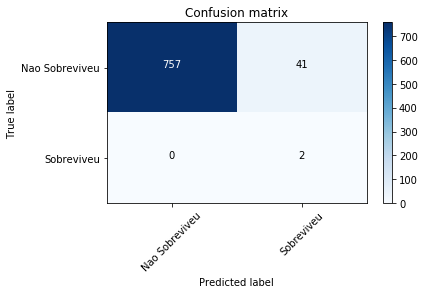

In [15]:
from sklearn import svm

clf_svc2 = svm.SVC(kernel='poly',
                   C=2.0,
                   degree=2, 
                   gamma=0.00001, 
                   coef0=0.0, 
                   shrinking=True, 
                   probability=False, 
                   tol=0.001, 
                   cache_size=200, 
                   class_weight=None, 
                   verbose=False, 
                   max_iter=-1, 
                   random_state=0).fit(X_traincv_res, y_traincv_res)

roc_svc2 = clf_eval(clf_svc2, X_testcv, y_testcv)

**Logistic Regression**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.98      0.99       798
    Sobreviveu       0.12      1.00      0.22         2

   avg / total       1.00      0.98      0.99       800

ROC Score: 0.991228070175
Accuracy Score: 0.9825
Average Precision Score: 0.125
f1 Score: 0.222222222222
Confusion matrix, without normalization
[[784  14]
 [  0   2]]


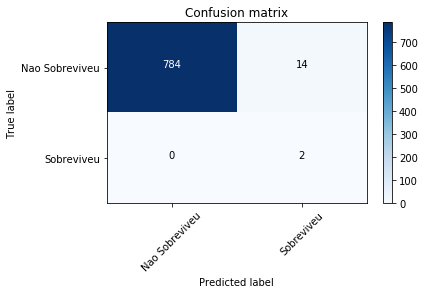

In [16]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            dual=False, 
                            tol=0.001, 
                            C=0.10, 
                            fit_intercept=True, 
                            intercept_scaling=1, 
                            class_weight=None, 
                            random_state=0, 
                            solver='saga', 
                            max_iter=100, 
                            multi_class='ovr', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=-1).fit(X_traincv_res, y_traincv_res)

roc_lr = clf_eval(clf_lr, X_testcv, y_testcv)

**Ridge Classifier**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.97      0.99       798
    Sobreviveu       0.00      0.00      0.00         2

   avg / total       0.99      0.97      0.98       800

ROC Score: 0.487468671679
Accuracy Score: 0.9725
Average Precision Score: 0.0025
f1 Score: 0.0
Confusion matrix, without normalization
[[778  20]
 [  2   0]]


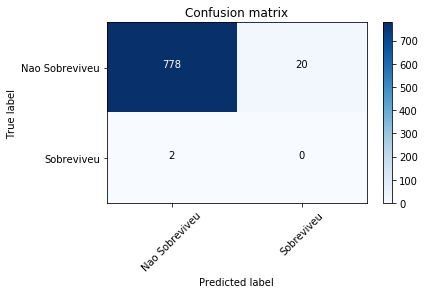

In [17]:
from sklearn.linear_model import RidgeClassifier

clf_rdg = RidgeClassifier(alpha=1.0, 
                          fit_intercept=True, 
                          normalize=False, 
                          copy_X=True, 
                          max_iter=None, 
                          tol=0.001, 
                          class_weight=None, 
                          solver='auto', 
                          random_state=0).fit(X_traincv_res, y_traincv_res)

roc_rdg = clf_eval(clf_rdg, X_testcv, y_testcv)

**Perceptron**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.99      0.99       798
    Sobreviveu       0.00      0.00      0.00         2

   avg / total       0.99      0.99      0.99       800

ROC Score: 0.495614035088
Accuracy Score: 0.98875
Average Precision Score: 0.0025
f1 Score: 0.0
Confusion matrix, without normalization
[[791   7]
 [  2   0]]


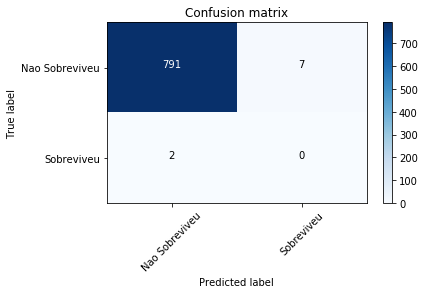

In [19]:
from sklearn.linear_model import Perceptron

clf_pcp = Perceptron(penalty=None,
                     alpha=0.001,
                     fit_intercept=True,
                     max_iter=230,
                     shuffle=True,
                     verbose=0,
                     eta0=1.0,
                     n_jobs=-1, 
                     random_state=0, 
                     class_weight=None, 
                     warm_start=False).fit(X_traincv_res, y_traincv_res)

roc_pcp = clf_eval(clf_pcp, X_testcv, y_testcv)

**Passive Agressive**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.99      1.00       798
    Sobreviveu       0.00      0.00      0.00         2

   avg / total       0.99      0.99      0.99       800

ROC Score: 0.497493734336
Accuracy Score: 0.9925
Average Precision Score: 0.0025
f1 Score: 0.0
Confusion matrix, without normalization
[[794   4]
 [  2   0]]


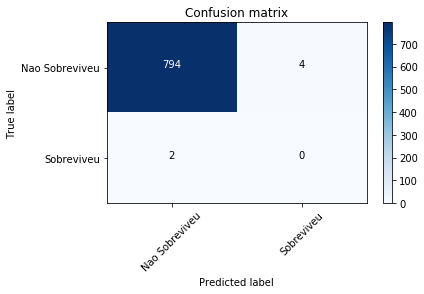

In [20]:
from sklearn.linear_model import PassiveAggressiveClassifier

clf_pac = PassiveAggressiveClassifier(C=0.1, 
                                      fit_intercept=True, 
                                      max_iter=100, 
                                      shuffle=True, 
                                      verbose=0, 
                                      loss='hinge', 
                                      n_jobs=-1, 
                                      random_state=0, 
                                      warm_start=False, 
                                      class_weight=None).fit(X_traincv_res, y_traincv_res)

roc_pac = clf_eval(clf_pac, X_testcv, y_testcv)

**SGDC Classifier**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.99      1.00       798
    Sobreviveu       0.00      0.00      0.00         2

   avg / total       0.99      0.99      0.99       800

ROC Score: 0.497493734336
Accuracy Score: 0.9925
Average Precision Score: 0.0025
f1 Score: 0.0
Confusion matrix, without normalization
[[794   4]
 [  2   0]]


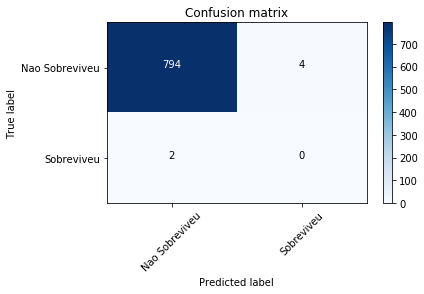

In [21]:
from sklearn.linear_model import SGDClassifier

clf_sgdc = SGDClassifier(loss='hinge',
                         penalty='l2', 
                         alpha=0.0001,
                         l1_ratio=0.15, 
                         fit_intercept=True,
                         max_iter=200, 
                         shuffle=True,
                         verbose=0,
                         epsilon=0.1,
                         n_jobs=-1,
                         random_state=0,
                         learning_rate='optimal',
                         eta0=0.0, 
                         power_t=0.5,
                         class_weight=None,
                         warm_start=False, 
                         average=False).fit(X_traincv_res, y_traincv_res)

roc_sgdc = clf_eval(clf_sgdc, X_testcv, y_testcv)

**K-Nearest Neighbors**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.87      0.93       798
    Sobreviveu       0.02      1.00      0.04         2

   avg / total       1.00      0.87      0.93       800

ROC Score: 0.93671679198
Accuracy Score: 0.87375
Average Precision Score: 0.0194174757282
f1 Score: 0.0380952380952
Confusion matrix, without normalization
[[697 101]
 [  0   2]]


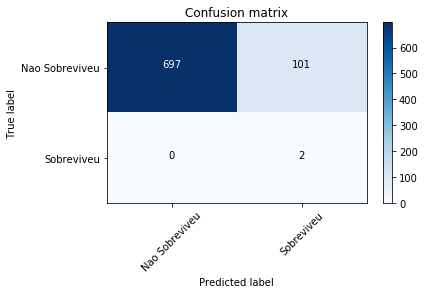

In [22]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=25,
                               weights='uniform', 
                               algorithm='auto', 
                               leaf_size=30, 
                               p=4, 
                               metric='minkowski', 
                               metric_params=None, 
                               n_jobs=-1).fit(X_traincv_res, y_traincv_res)

roc_knn = clf_eval(clf_knn, X_testcv, y_testcv)

**Decision Tree**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      1.00      1.00       798
    Sobreviveu       0.00      0.00      0.00         2

   avg / total       1.00      1.00      1.00       800

ROC Score: 0.499373433584
Accuracy Score: 0.99625
Average Precision Score: 0.0025
f1 Score: 0.0
Confusion matrix, without normalization
[[797   1]
 [  2   0]]


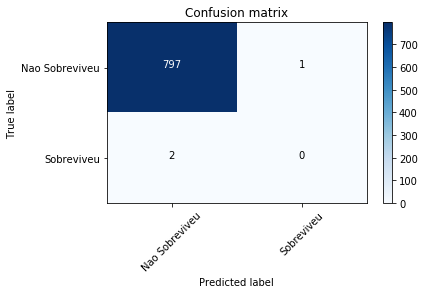

In [23]:
from sklearn.tree import DecisionTreeClassifier

clf_dtc = DecisionTreeClassifier(criterion='gini', 
                                 splitter='best', 
                                 max_depth=None, 
                                 min_samples_split=3, 
                                 min_samples_leaf=1, 
                                 min_weight_fraction_leaf=0.0, 
                                 max_features=None, 
                                 random_state=0, 
                                 max_leaf_nodes=None, 
                                 class_weight=None, 
                                 presort=False).fit(X_traincv_res, y_traincv_res)

roc_dtc = clf_eval(clf_dtc, X_testcv, y_testcv)

**Random Forest**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      1.00      1.00       798
    Sobreviveu       0.00      0.00      0.00         2

   avg / total       1.00      1.00      1.00       800

ROC Score: 0.5
Accuracy Score: 0.9975
Average Precision Score: 0.0025
f1 Score: 0.0
Confusion matrix, without normalization
[[798   0]
 [  2   0]]


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


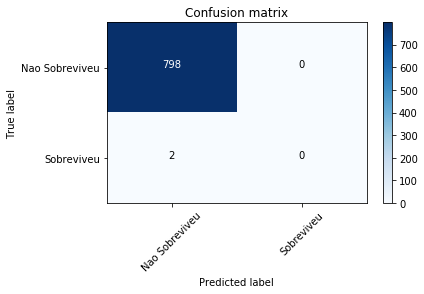

In [24]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=300, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=3, #2,
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None).fit(X_traincv_res, y_traincv_res)

roc_rf = clf_eval(clf_rf, X_testcv, y_testcv)

**Bagging**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      1.00      1.00       798
    Sobreviveu       0.00      0.00      0.00         2

   avg / total       0.99      0.99      0.99       800

ROC Score: 0.498746867168
Accuracy Score: 0.995
Average Precision Score: 0.0025
f1 Score: 0.0
Confusion matrix, without normalization
[[796   2]
 [  2   0]]


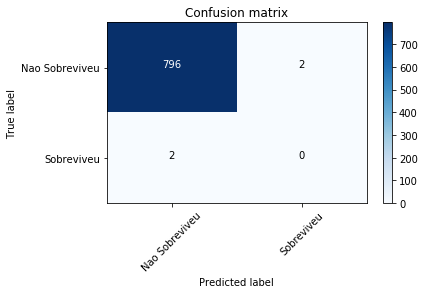

In [25]:
from sklearn.ensemble import BaggingClassifier

clf_bgc = BaggingClassifier().fit(X_traincv_res, y_traincv_res)

roc_bgc = clf_eval(clf_bgc, X_testcv, y_testcv)

**Extra Trees**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      1.00      1.00       798
    Sobreviveu       0.00      0.00      0.00         2

   avg / total       1.00      1.00      1.00       800

ROC Score: 0.499373433584
Accuracy Score: 0.99625
Average Precision Score: 0.0025
f1 Score: 0.0
Confusion matrix, without normalization
[[797   1]
 [  2   0]]


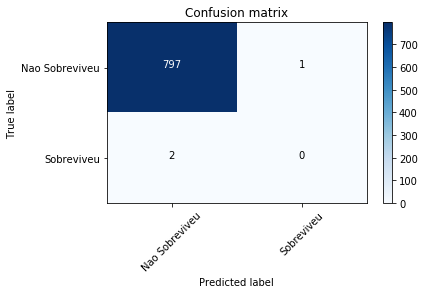

In [29]:
from sklearn.ensemble import ExtraTreesClassifier

clf_etc = ExtraTreesClassifier(n_estimators=300,
                               max_depth=None,
                               min_samples_split=3,
                               random_state=0).fit(X_traincv_res, y_traincv_res)

roc_etc = clf_eval(clf_etc, X_testcv, y_testcv)

**Boosting**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      1.00      1.00       798
    Sobreviveu       0.00      0.00      0.00         2

   avg / total       1.00      1.00      1.00       800

ROC Score: 0.5
Accuracy Score: 0.9975
Average Precision Score: 0.0025
f1 Score: 0.0
Confusion matrix, without normalization
[[798   0]
 [  2   0]]


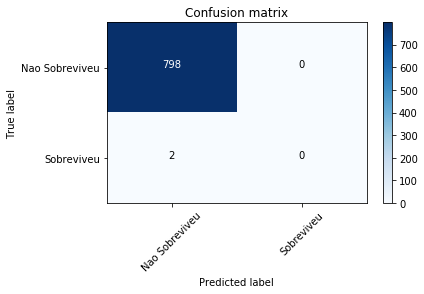

In [30]:
from sklearn.ensemble import AdaBoostClassifier

clf_abc = AdaBoostClassifier(base_estimator=None,
                             n_estimators=300,
                             learning_rate=0.1,
                             algorithm='SAMME.R',
                             random_state=0).fit(X_traincv_res, y_traincv_res)

roc_abc = clf_eval(clf_abc, X_testcv, y_testcv)

**Bayesian Classifiers**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.99      0.99       798
    Sobreviveu       0.10      0.50      0.17         2

   avg / total       1.00      0.99      0.99       800

ROC Score: 0.744360902256
Accuracy Score: 0.9875
Average Precision Score: 0.05125
f1 Score: 0.166666666667
Confusion matrix, without normalization
[[789   9]
 [  1   1]]


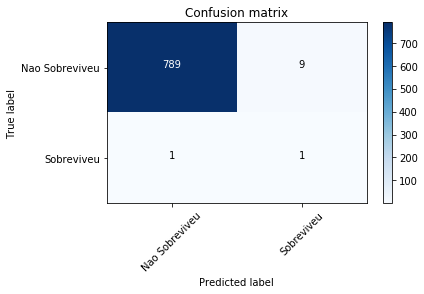

In [31]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB().fit(X_traincv_res, y_traincv_res)

roc_gnb = clf_eval(clf_gnb, X_testcv, y_testcv)

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.99      0.99       798
    Sobreviveu       0.17      1.00      0.29         2

   avg / total       1.00      0.99      0.99       800

ROC Score: 0.99373433584
Accuracy Score: 0.9875
Average Precision Score: 0.166666666667
f1 Score: 0.285714285714
Confusion matrix, without normalization
[[788  10]
 [  0   2]]


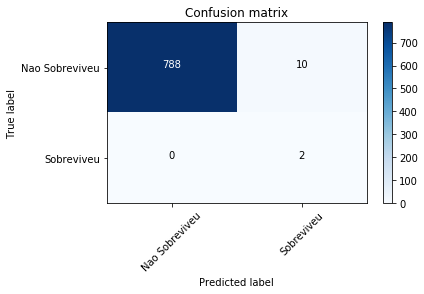

In [32]:
from sklearn.naive_bayes import BernoulliNB

clf_bnb = BernoulliNB(alpha=0.20, 
                     binarize=0.0, 
                     fit_prior=True, 
                     class_prior=None).fit(X_traincv_res, y_traincv_res)

roc_bnb = clf_eval(clf_bnb, X_testcv, y_testcv)

**Gaussian Process**

Classification Report
                precision    recall  f1-score   support

Nao Sobreviveu       1.00      0.99      1.00       798
    Sobreviveu       0.25      1.00      0.40         2

   avg / total       1.00      0.99      0.99       800

ROC Score: 0.996240601504
Accuracy Score: 0.9925
Average Precision Score: 0.25
f1 Score: 0.4
Confusion matrix, without normalization
[[792   6]
 [  0   2]]


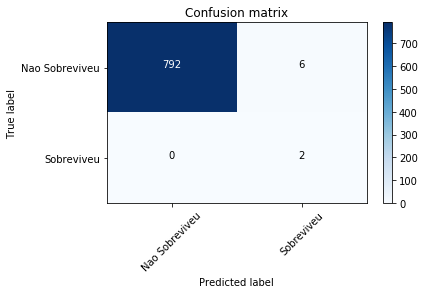

In [34]:
from sklearn.gaussian_process import GaussianProcessClassifier


clf_gpc = GaussianProcessClassifier(kernel=None, 
                                    optimizer='fmin_l_bfgs_b', 
                                    n_restarts_optimizer=0, 
                                    max_iter_predict=100, 
                                    warm_start=False, 
                                    copy_X_train=True, 
                                    random_state=0, 
                                    multi_class='one_vs_rest', 
                                    n_jobs=-1).fit(X_traincv_res, y_traincv_res)

roc_gpc = clf_eval(clf_gpc, X_testcv, y_testcv)